In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import string
from unidecode import unidecode
import emoji

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc


import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

## Data loading

In [2]:
file_train = 'train_spam.csv'

data_train_all = pd.read_csv(file_train)

In [3]:
texts_train_all = data_train_all['text'].to_list()
labels_all = data_train_all['text_type']
target_all = pd.Categorical(labels_all, categories=['ham', 'spam']).codes

In [4]:
print(texts_train_all[1])

a resume for john lavorato thanks vince i will get moving on it right away molly vince j kaminski 02 21 2001 05 55 pm to molly magee hou ect ect cc vince j kaminski hou ect ect subject a resume for john lavorato molly please make arrangements for the interview with this candidate for a trading position interviews with john lavorato jeff shankman gary hickerson stinson gibner i talked to him in new york and he is considering other opportunities so we have to act fast i think john will like him more than punit thanks


## Preprocessing functions

In [5]:
lemmatizer = WordNetLemmatizer()

tokenizer = TweetTokenizer()

ENGLISH_STOP_WORDS = set(stopwords.words('english'))

In [6]:
def to_lower(words):
    result = words.lower()
    return result


def remove_underscore(words):
    return re.sub(r'_', ' ', words)

def remove_punctuation(words):
    result = re.sub(r'[!"#%&\'()*+,-./:;<=>?@\[\]^`{|}~]', ' ', words) # everything except underscore and $
    return result


def replace_hyperlink(words, replace=' <HTTP> '):
    return re.sub(r'http(?:\S*|\b)', replace, words)

def remove_hyperlink(words):
    return replace_hyperlink(words, '')


def emoji_to_text(words):
    return emoji.demojize(words)

def replace_emoji(words,  replace=' <EMOJI> '):
    return emoji.replace_emoji(words, replace=replace)

def remove_emoji(words):
    return replace_emoji(words, '')


def replace_non_ascii_words(words, replace=' <NONASCII> '):
    pattern = r'\b[^\x00-\x7F]+\b'
    non_ascii_words = re.sub(pattern, replace, words)
    return non_ascii_words

def replace_non_ascii(words, replace=' <NONASCII> '):
    pattern = r'[^\x00-\x7F]'
    non_ascii_words = re.sub(pattern, replace, words)
    return non_ascii_words

def remove_non_ascii(words):
    return unidecode(words)


def replace_number(words, replace=' <NUMBER> '):
    result = re.sub(r'\w*\d\w*', replace, words)
    return result

def remove_number(words):
    return replace_number(words, '')


def replace_currency(words, replace=' <CURRENCY> '):
    currency_pattern = r'[£$€₹]'
    return re.sub(currency_pattern, replace, words)

def remove_currency(words):
    return replace_currency(words, '')


def replace_tag(words, replace=' <TAG> '):
    return re.sub(r'\w*@\w*', replace, words)

def replace_exclamation(words, replace=' <EXCLAMATION> '):
    return re.sub(r'!', replace, words)

def replace_question(words, replace=' <QUESTION> '):
    return re.sub(r'\?', replace, words)

def replace_slash(words, replace=' <SLASH> '):
    return re.sub(r'/', replace, words)

def replace_colon(words, replace=' <COLON> '):
    return re.sub(r':', replace, words)


def remove_whitespace(words):
    return words.strip()

def replace_newline(words):
    return words.replace('\n', ' ')

def remove_stop_words(words):
    return [i for i in words if i not in ENGLISH_STOP_WORDS]

def word_lemmatizer(words):
    return [lemmatizer.lemmatize(s) for s in words]

In [7]:
def print_tokenized_data(data_tokenized, b=0, e=None):
    for sentence in data_tokenized[b:e]:
        print(' '.join(sentence))


def preprocess_pipeline(sentence, preprocess_utils=None):
    if preprocess_utils is None:
        preprocess_utils = [
            to_lower,
            replace_newline,
            remove_underscore,
            replace_hyperlink,
            replace_emoji,
            replace_non_ascii_words,
            replace_non_ascii,
            remove_non_ascii,
            remove_punctuation,
            remove_whitespace,
            tokenizer.tokenize,
            remove_stop_words,
            word_lemmatizer,
        ]
    for func in preprocess_utils:
        sentence = func(sentence)
    return sentence

In [8]:
def calc_metrics(model, X_test, y_test):
    prob_pred = model.predict_proba(X_test.toarray())
    y_pred = np.argmax(prob_pred, axis=1)
    p_pred = prob_pred[:, 1]

    return (
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, p_pred)
    )

## Оценим модель

In [18]:
def evaluate_model(data_train_tokenized, preprocess_utils, max_features=35000, min_df=1):
    # spliting to train and validation
    texts_train, texts_val, y_train, y_val = train_test_split(
                                        data_train_tokenized,
                                        target_all,
                                        shuffle=True,
                                        random_state=42, 
                                        stratify=target_all)

    texts_train_strings = [" ".join(sentence) for sentence in texts_train]
    texts_val_strings = [" ".join(sentence) for sentence in texts_val]

    # creating TF-IDF features
    vectorizer = TfidfVectorizer(lowercase=False, max_features=max_features, min_df=min_df)
    vectorizer.fit(texts_train_strings)

    X_train = vectorizer.transform(texts_train_strings)
    X_val = vectorizer.transform(texts_val_strings)

    # Training model
    clf = GaussianNB()
    clf.fit(X_train.toarray(), y_train)

    # Evaluating model
    (accuracy_val,
    precision_val,
    recall_val,
    f1_val,
    roc_auc_val) = calc_metrics(clf, X_val, y_val)

    print(f'Accuracy {accuracy_val:.4f}, Precision {precision_val:.4f}, ', end='')
    print(f'Recall {recall_val:.4f}, f1 {f1_val:.4f}, ROC AUC {roc_auc_val:.4f}')

    return roc_auc_val, clf, vectorizer
    

Будем использовать такуюже токенизацию данных как и в ManualFeatures

In [15]:
preprocess_utils = [
    to_lower,
    replace_newline,
    replace_hyperlink,
    remove_underscore,
    replace_currency,
    replace_emoji,
    replace_non_ascii_words,
    replace_non_ascii,
    remove_non_ascii,
    replace_number,
    replace_tag,
    replace_exclamation,
    replace_question,
    replace_slash,
    replace_colon,
    remove_punctuation,
    remove_whitespace,
    tokenizer.tokenize,
    remove_stop_words,
    word_lemmatizer,
]

data_train_tokenized = [
    preprocess_pipeline(sent, preprocess_utils) for sent in texts_train_all
]

In [17]:
max_features_list = [100, 500, 1000, 5000, 10000, 35000]

for mf in max_features_list:
    print(f'max_features = {mf}')
    roc_auc_val, clf, vectorizer = evaluate_model(
                                        data_train_tokenized,
                                        preprocess_utils,
                                        max_features=mf
                                    )
    print()

max_features = 100
Accuracy 0.6686, Precision 0.4698, Recall 0.9509, f1 0.6289, ROC AUC 0.7951

max_features = 500
Accuracy 0.7211, Precision 0.5151, Recall 0.9517, f1 0.6684, ROC AUC 0.8022

max_features = 1000
Accuracy 0.7386, Precision 0.5320, Recall 0.9542, f1 0.6831, ROC AUC 0.8082

max_features = 5000
Accuracy 0.7509, Precision 0.5473, Recall 0.9043, f1 0.6819, ROC AUC 0.7959

max_features = 10000
Accuracy 0.7459, Precision 0.5442, Recall 0.8611, f1 0.6669, ROC AUC 0.7798

max_features = 35000
Accuracy 0.7590, Precision 0.5627, Recall 0.8253, f1 0.6691, ROC AUC 0.7782



Видно, что наилучший ROC AUC достигается при max_features порядка 1000. Однако при этом несколько ухудшаются accuracy, presicion и f1 score

In [23]:
min_df_list = [50, 100, 200, 250, 300]

for mdf in min_df_list:
    print(f'min_df = {mdf}')
    roc_auc_val, clf, vectorizer = evaluate_model(
                                        data_train_tokenized,
                                        preprocess_utils,
                                        max_features=None,
                                        min_df = mdf
                                    )
    print(f'Vocab size {len(vectorizer.vocabulary_)}')
    print()

min_df = 50
Accuracy 0.7568, Precision 0.5517, Recall 0.9418, f1 0.6958, ROC AUC 0.8186
Vocab size 1144

min_df = 100
Accuracy 0.7504, Precision 0.5455, Recall 0.9285, f1 0.6872, ROC AUC 0.8182
Vocab size 536

min_df = 200
Accuracy 0.7344, Precision 0.5285, Recall 0.9334, f1 0.6749, ROC AUC 0.8272
Vocab size 242

min_df = 250
Accuracy 0.6998, Precision 0.4956, Recall 0.9343, f1 0.6476, ROC AUC 0.8090
Vocab size 179

min_df = 300
Accuracy 0.7015, Precision 0.4971, Recall 0.9301, f1 0.6479, ROC AUC 0.8168
Vocab size 134



Ограничение минимальной частоты нахождения слов в текстах позволило. Немного повысить ROC AUC по стравнению с контролем только максимального размера словаря.

Максимальный ROC AUC достигается при min_df = 200.

### Изобразим ROC

In [25]:
roc_auc_val, clf, vectorizer = evaluate_model(
                                        data_train_tokenized,
                                        preprocess_utils,
                                        max_features=None,
                                        min_df = 200
                                    )

texts_train, texts_val, y_train, y_val = train_test_split(
                                    data_train_tokenized,
                                    target_all,
                                    shuffle=True,
                                    random_state=42, 
                                    stratify=target_all)

texts_val_strings = [" ".join(sentence) for sentence in texts_val]

X_val = vectorizer.transform(texts_val_strings)

prob_pred = clf.predict_proba(X_val.toarray())
p_pred = prob_pred[:, 1]

Accuracy 0.7344, Precision 0.5285, Recall 0.9334, f1 0.6749, ROC AUC 0.8272


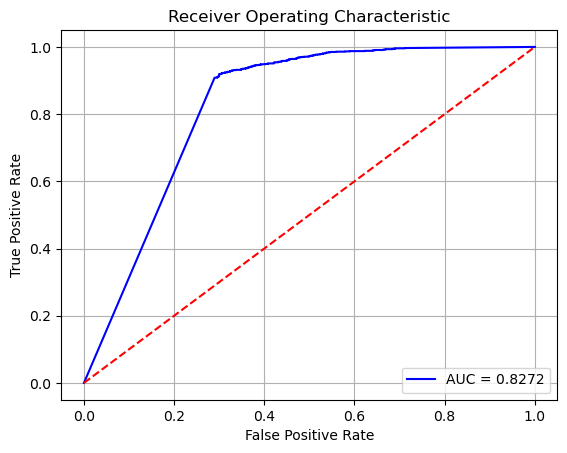

In [28]:
fpr, tpr, threshold = roc_curve(y_val, p_pred)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc_val:0.4f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()